In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

In [2]:
# Load the store sales dataset
excel_file = pd.ExcelFile('data/store_sales.xlsx')
sheet_names = excel_file.sheet_names

# Read the data
results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
iri_key_counts = results_df['IRI_KEY'].value_counts()
iri_keys = iri_key_counts[iri_key_counts > 300].index


features = ['F', 'D', 'Unit.Price']
target = 'Total.Volume'

results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
X = results_df[features].values
y = results_df[target].values

sheet_names, iri_keys, X.shape, y.shape

(['StoreWeekSalescarbbev_modify',
  'StoreWeekSalescigets',
  'StoreWeekSalescoffee',
  'StoreWeekSalescoldcer',
  'StoreWeekSalesdeod',
  'StoreWeekSalesdiapers',
  'StoreWeekSalesfactiss',
  'StoreWeekSalesfzdinent',
  'StoreWeekSalesfzpizza',
  'StoreWeekSaleshotdog',
  'StoreWeekSaleslaundet',
  'StoreWeekSalesmargbutr',
  'StoreWeekSalesmayo',
  'StoreWeekSalesmustketc',
  'StoreWeekSalespaptowl',
  'StoreWeekSalespeanbutr',
  'StoreWeekSalesshamp',
  'StoreWeekSalessoup',
  'StoreWeekSalesspagsauc',
  'StoreWeekSalessugarsub',
  'StoreWeekSalestoitisu',
  'StoreWeekSalestoothpa',
  'StoreWeekSalesyogurt',
  'StoreWeekSalesbeer_modify'],
 Index([6001821.0,  648368.0,  279300.0,  400003.0,  270862.0,  231720.0,
         252570.0,  659827.0,  241565.0,  237277.0,  291276.0,  273920.0,
         232633.0,  233246.0,  532639.0,  533864.0],
       dtype='float64', name='IRI_KEY'),
 (313, 3),
 (313,))

In [3]:
# Load the Boston dataset
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22,  # type: ignore
                     header=None)  # type: ignore
X = np.hstack([raw_df.values[::2, :-1], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2].reshape(-1, 1).ravel()
X.shape, y.shape

((506, 12), (506,))

In [4]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # print(raw_df.head())
# X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
#                       34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]] # 9, 12
# y = raw_df.values[:-1, 11]
# X.shape, y.shape

In [5]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # type: ignore

In [6]:
from sklearn.model_selection import GridSearchCV
from models_sklearn import Ensemble, MLP, FONN1, FONN2, TREENN1, TREENN2
from models import MLP as MLP_2, FONN1 as FONN1_2, FONN2 as FONN2_2, TREENN1 as TREENN1_2, TREENN2 as TREENN2_2


grid_search_params = {
    'scoring': 'neg_root_mean_squared_error',
    'n_jobs': -1,
    'verbose': 1,
    'return_train_score': True
}

ensemble_param_grid = {
}

mlp_param_grid = {
    # 'max_iter': [1000, 100, 2000],
    'max_iter': [1000],
    'learning_rate': ['constant'],
    # 'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [1e-1, 1e-2, 1e-3],
    # 'learning_rate_init': [1e1, 1e-2, 1e-3],
    # 'tol': [1e-4],
    'early_stopping': [True]
    # 'early_stopping': [True, False],
}

models = {}
models['Tree'] = GridSearchCV(
    Ensemble(1), ensemble_param_grid, **grid_search_params)
models['Ensemble 5'] = GridSearchCV(
    Ensemble(5), ensemble_param_grid, **grid_search_params)
models['MLP 5'] = GridSearchCV(MLP(5), mlp_param_grid, **grid_search_params)
models['FONN1 5 5'] = GridSearchCV(
    FONN1(5, (10,)), mlp_param_grid, **grid_search_params)
models['FONN2 5 5'] = GridSearchCV(
    FONN2(5, (10,)), mlp_param_grid, **grid_search_params)
models['TREENN1 5'] = GridSearchCV(
    TREENN1((6,)), mlp_param_grid, **grid_search_params)
models['TREENN2 5'] = GridSearchCV(
    TREENN2((6,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 10'] = GridSearchCV(
#     Ensemble(10), ensemble_param_grid, **grid_search_params)
# models['MLP 10'] = GridSearchCV(
#     MLP(10), mlp_param_grid, **grid_search_params)
# models['FONN1 5 10'] = GridSearchCV(
#     FONN1(5, (10,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 10'] = GridSearchCV(
#     FONN2(5, (10,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 10'] = GridSearchCV(
#     TREENN1((11,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 10'] = GridSearchCV(
#     TREENN2((11,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 40'] = GridSearchCV(
#     Ensemble(40), ensemble_param_grid, **grid_search_params)
# models['MLP 40'] = GridSearchCV(
#     MLP(40), mlp_param_grid, **grid_search_params)
# models['FONN1 5 40'] = GridSearchCV(
#     FONN1(5, (45,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 40'] = GridSearchCV(
#     FONN2(5, (45,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 40'] = GridSearchCV(
#     TREENN1((41,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 40'] = GridSearchCV(
#     TREENN2((41,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 100'] = GridSearchCV(
#     Ensemble(100), ensemble_param_grid, **grid_search_params)
# models['MLP 100'] = GridSearchCV(
#     MLP(100), mlp_param_grid, **grid_search_params)
# models['FONN1 5 100'] = GridSearchCV(
#     FONN1(5, (105,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 100'] = GridSearchCV(
#     FONN2(5, (105,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 100'] = GridSearchCV(
#     TREENN1((101,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 100'] = GridSearchCV(
#     TREENN2((101,)), mlp_param_grid, **grid_search_params)

mlp_param_grid_2 = {
    'epochs': [4000, 1000],
    # 'learning_rate': [1e1, 1e0, 1e-1, 1e-2],
    'learning_rate': [1e-2, 1e-3],
}

# input_dim = X.shape[1]
# hidden_dim = 10
# output_dim = 1

# models['MLP_2 10'] = GridSearchCV(
#     MLP_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)

# num_trees_input = 5
# models['FONN1_2 5 10'] = GridSearchCV(
#     FONN1_2(input_dim, hidden_dim, output_dim, num_trees_input), mlp_param_grid_2, **grid_search_params)

# num_trees_hidden = 5
# models['FONN2_2 5 10'] = GridSearchCV(
#     FONN2_2(input_dim, hidden_dim, output_dim, num_trees_hidden), mlp_param_grid_2, **grid_search_params)

# # models['TREENN1_2 10'] = GridSearchCV(
# #     TREENN1_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)

# # models['TREENN2_2 10'] = GridSearchCV(
# #     TREENN2_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)
# models['TREENN1_2 10'] = GridSearchCV(
#     FONN1_2(input_dim, hidden_dim, output_dim, 1), mlp_param_grid_2, **grid_search_params)

# models['TREENN2_2 10'] = GridSearchCV(
#     FONN2_2(input_dim, hidden_dim, output_dim, 1), mlp_param_grid_2, **grid_search_params)

# models['Tree-based Predictions (FONN2)'] = models['FONN2'].trees
# models['Tree-based Predictions (TREENN2)'] = models['TREENN2'].trees

In [7]:
# Train and evaluate models
cv_results = {}
results = []
for name, model in models.items():
    model.fit(X, y)
    result = model.cv_results_
    results.append({
        'model': name,
        'mean_fit_time': result['mean_fit_time'][model.best_index_],
        'mean_score_time': result['mean_score_time'][model.best_index_],
        'mean_train_score': result['mean_train_score'][model.best_index_],
        'mean_test_score': result['mean_test_score'][model.best_index_],
        'params': result['params'][model.best_index_]
    })
    cv_results[name] = result

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df
# results_df = pd.DataFrame(
#     results, columns=['model', 'r2', 'mae', 'mse', 'train_time', 'comp_time', 'n_iter'])
# results_df.set_index('model', inplace=True)
# results_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,params
model,,,,,
Tree,0.005989,0.001210,-0.296217,-0.610641,{}
Ensemble 5,0.023935,0.001429,-0.169917,-0.510136,{}
MLP 5,0.387654,0.000860,-0.523340,-0.616360,"{'early_stopping': True, 'learning_rate': 'con..."
FONN1 5 5,0.149280,0.002384,-0.172481,-0.557865,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2 5 5,0.188489,0.000604,-0.565345,-0.640048,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN1 5,0.277372,0.000901,-0.338831,-0.531822,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN2 5,0.602884,0.000694,-0.458995,-0.592528,"{'early_stopping': True, 'learning_rate': 'con..."


In [8]:
[result['params'] for result in results], cv_results

([{},
  {},
  {'early_stopping': True,
   'learning_rate': 'constant',
   'learning_rate_init': 0.001,
   'max_iter': 1000},
  {'early_stopping': True,
   'learning_rate': 'constant',
   'learning_rate_init': 0.1,
   'max_iter': 1000},
  {'early_stopping': True,
   'learning_rate': 'constant',
   'learning_rate_init': 0.01,
   'max_iter': 1000},
  {'early_stopping': True,
   'learning_rate': 'constant',
   'learning_rate_init': 0.001,
   'max_iter': 1000},
  {'early_stopping': True,
   'learning_rate': 'constant',
   'learning_rate_init': 0.001,
   'max_iter': 1000}],
 {'Tree': {'mean_fit_time': array([0.00598865]),
   'std_fit_time': array([0.00035386]),
   'mean_score_time': array([0.00121002]),
   'std_score_time': array([0.00014495]),
   'params': [{}],
   'split0_test_score': array([-0.43423878]),
   'split1_test_score': array([-0.71650373]),
   'split2_test_score': array([-0.51832242]),
   'split3_test_score': array([-0.73285377]),
   'split4_test_score': array([-0.65128582]),
  

In [9]:
results_df.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,params
model,,,,,
Ensemble 5,0.023935,0.001429,-0.169917,-0.510136,{}
TREENN1 5,0.277372,0.000901,-0.338831,-0.531822,"{'early_stopping': True, 'learning_rate': 'con..."
FONN1 5 5,0.149280,0.002384,-0.172481,-0.557865,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN2 5,0.602884,0.000694,-0.458995,-0.592528,"{'early_stopping': True, 'learning_rate': 'con..."
Tree,0.005989,0.001210,-0.296217,-0.610641,{}
MLP 5,0.387654,0.000860,-0.523340,-0.616360,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2 5 5,0.188489,0.000604,-0.565345,-0.640048,"{'early_stopping': True, 'learning_rate': 'con..."


In [10]:
dataset_rank = results_df[['mean_test_score']].rank(numeric_only=True)
dataset_rank = dataset_rank.assign(Mean=dataset_rank.mean(1), Stddev=dataset_rank.std(1))
dataset_rank

,mean_test_score,Mean,Stddev
model,,,
Tree,3.0,3.0,NaN
Ensemble 5,7.0,7.0,NaN
MLP 5,2.0,2.0,NaN
FONN1 5 5,5.0,5.0,NaN
FONN2 5 5,1.0,1.0,NaN
TREENN1 5,6.0,6.0,NaN
TREENN2 5,4.0,4.0,NaN


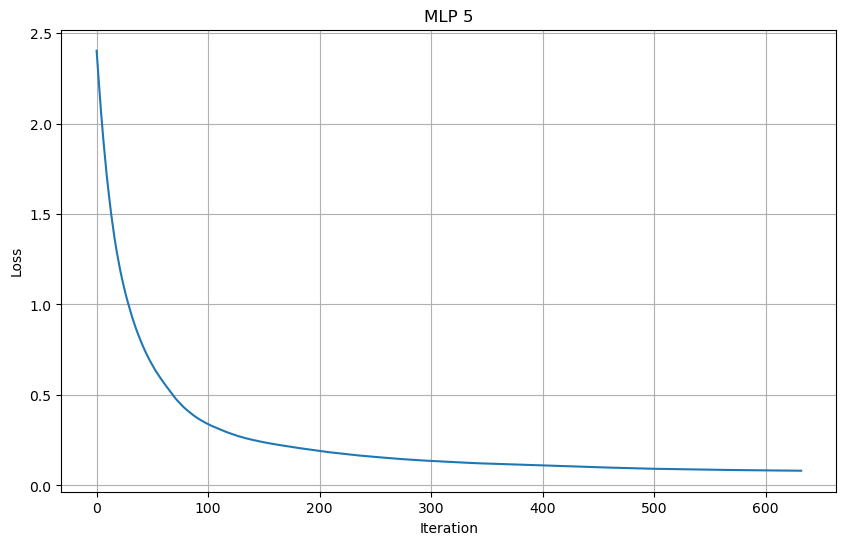

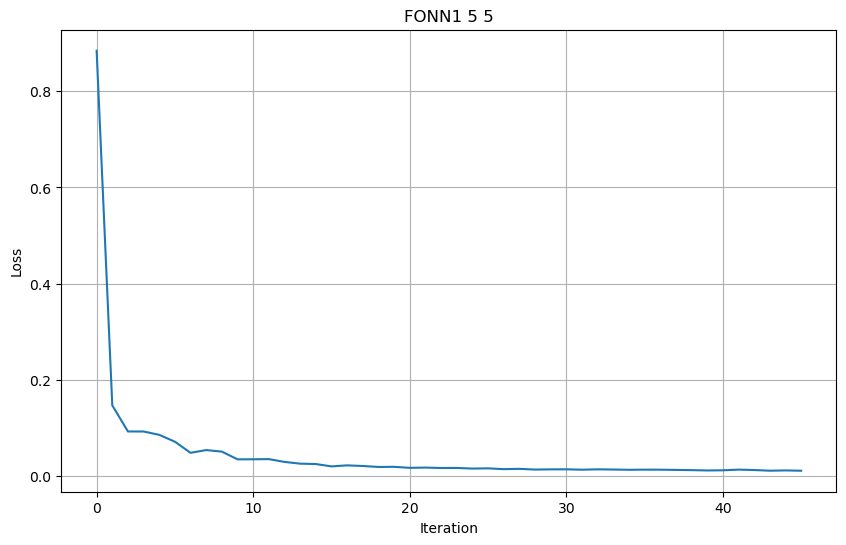

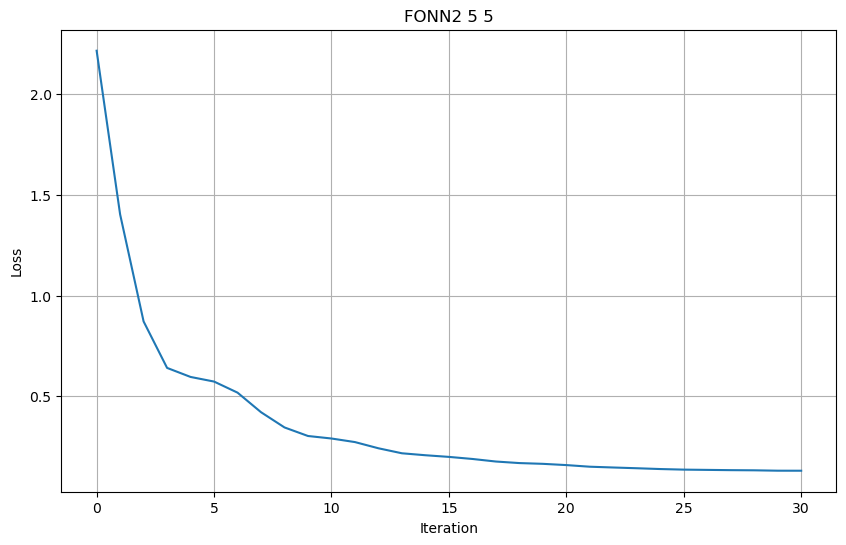

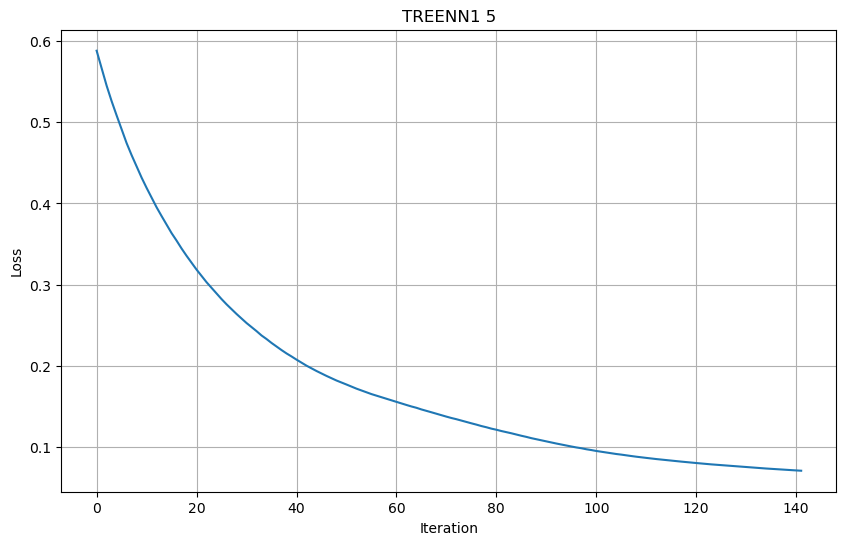

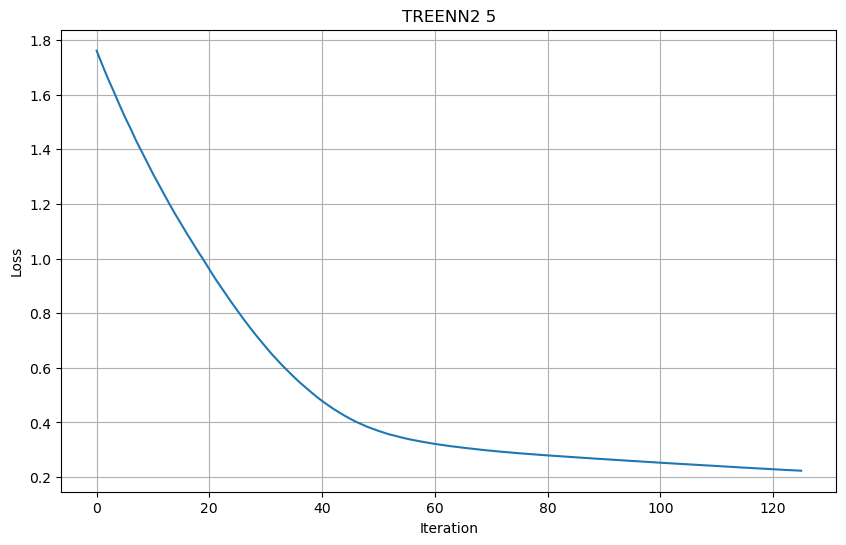

In [11]:
import matplotlib.pyplot as plt


def plot_loss(model, title='Loss Curve'):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_curve_)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid()
    plt.show()

for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        plot_loss(model.best_estimator_, model_name)